# Notes

This notebook updates Pipe_Creation_Plus_LSS_7.ipynb.

- It builds upon the Zhang+20 method of creating DMs from the TNG simulation.
- It improves upon this by correcting ElectronAbundance in star-forming regions using the Pakmor+18 method allowing them to be used. To do this it calculates the warm-phase gas mass fraction W (=1-X, where X is from Marinacci+17)
- It identifies LSS using the Artale+21 method.
- It inserts code developed to load snapshots partwise to handle larger simulations
- It saves output data to file as it is created, which allows it to be stopped and resumed rather than being started from scratch.
- It removes unecessary tests and plots and incorporates all code into a single cell, which can be copied into a .py file to be run as a batch job.
- It stores Particle ID and location information which can be used to calculate halo impact factors along tthe line of sight.
- It contains an option for multiprocessing different pipes on multiple cpus simultaneously to speed up pipe creation
- It cleans up Pipe_Creation_Plus_LSS_6.ipynb, removing much of the testing.

Notes: 

- The lines of code which save pipes have been commented out in this version of the code in order not to overwrite existing file
- When running on a Jupyter notebook, it seems to begin failing after requesting around 6-7+ cpus simultaneously. This may be an issue with the interactive nodes. Hopeefully, in a script we should be able to use many more (50-70)

ELECTRON DENSITY OF SFR CODE ARCHIVE

raven:/u/cwalker/Illustris_FRB_Project/oct2_2021_output/IGM_new_scripts/job_raven.py, raven:/u/cwalker/Illustris_FRB_Project/charlie_TNG_lib/charlie_TNG_tools.py
PAPERS: Marinacci+17: https://arxiv.org/abs/1610.01594, Pakmor+18: https://arxiv.org/abs/1807.02113

PIPE CREATION CODE ARCHIVE

raven:/u/cwalker/Illustris_Zhang_Method/Pipe_Creation_Test.ipynb, raven:/u/cwalker/Illustris_Zhang_Method/Pipe_Creation_Plus_LSS.ipynb, raven:/u/cwalker/Illustris_Zhang_Method/Pipe_Creation_Plus_LSS.ipynb
PAPERS: Zhang+20: https://arxiv.org/abs/2011.14494

LSS CLASSIFICATION CODE ARCHIVE

raven:/u/cwalker/Illustris_FRB_Project/git_Illustris_uploads/mass_fraction_plots/artale_test_121121/SCRIPT_Cel_Auto.py, raven:/u/cwalker/Illustris_FRB_Project/yt-artale-constants.ipynb
PAPERS: Artale+21: https://arxiv.org/abs/2102.01092

PARTWISE SIMULATION LOADING ARCHIVE

raven:/u/cwalker/Illustris_Zhang_Method/Test_Subset_Loading.ipynb


# Imports

In [1]:
import illustris_python as il
import numpy as np
import multiprocessing as m
from multiprocessing import Pool
from contextlib import closing

from numpy import random as rand
from charlie_TNG_tools import temp2u
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import binned_statistic_dd
from astropy import constants as c
#from artale_constants import *
from astropy.cosmology import Planck15 as cosmosource
import h5py
import os

# Functions

In [2]:
def gadgetDens2SI(dens):
    """
    Original Artale function to convert TNG densities to SI units

    INPUTSRETURNS:

    dens : [values] densities from TNG

    RETURNS:

    dens converted to SI units
    """
    return dens*1E10*cel_Msol_si/cel_hubble/(cel_kpc_si/cel_hubble)**3

def TNG_Dens2SI(dens):
    """
    Like gadgetDens2SI but using astropy values for constants
    Strips result of units
    Developed in raven:/u/cwalker/Illustris_FRB_Project/yt-artale-constants.ipynb


    INPUTSRETURNS:

    dens : [values] densities from TNG

    RETURNS:

    dens converted to SI units
    """
    return dens*1E10*c.M_sun.to('kg').value/cosmosource.h/(c.kpc.to('m').value/cosmosource.h)**3

def TNG_Dens2SI_astropy(dens):
    """
    Like TNG_Dens2SI but does not strip result of units.
    Developed in raven:/u/cwalker/Illustris_FRB_Project/yt-artale-constants.ipynb


    INPUTSRETURNS:

    dens : [values] densities from TNG

    RETURNS:

    dens converted to SI units
    """

    return dens*1E10*c.M_sun.to('kg')/cosmosource.h/(c.kpc.to('m')/cosmosource.h)**3

   
def pSplitRange(indrange, numProcs, curProc, inclusive=False):
    """ Divide work for embarassingly parallel problems. 
    Accept a 2-tuple of [start,end] indices and return a new range subset.
    If inclusive==True, then assume the range subset will be used e.g. as input to snapshotSubseet(),
    which unlike numpy convention is inclusive in the indices."""
    assert len(indrange) == 2 and indrange[1] > indrange[0]

    if numProcs == 1:
        if curProc != 0:
            raise Exception("Only a single processor but requested curProc>0.")
        return indrange

    # split array into numProcs segments, and return the curProc'th segment
    splitSize = int(np.floor( (indrange[1]-indrange[0]) / numProcs ))
    start = indrange[0] + curProc*splitSize
    end   = indrange[0] + (curProc+1)*splitSize

    # for last split, make sure it takes any leftovers
    if curProc == numProcs-1:
        end = indrange[1]

    if inclusive and curProc < numProcs-1:
        # not for last split/final index, because this should be e.g. NumPart[0]-1 already
        end -= 1

    return [start,end]


def loadSubset(simPath, snap, partType, fields, chunkNum=0, totNumChunks=1):
    """ 
    Load part of a snapshot.
    frm Dylan Nelson: https://www.tng-project.org/data/forum/topic/203/loading-the-tng100-1-data/
    """
    nTypes = 6
    ptNum = il.util.partTypeNum(partType)

    with h5py.File(il.snapshot.snapPath(simPath,snap),'r') as f:
        numPartTot = il.snapshot.getNumPart( dict(f['Header'].attrs.items()) )[ptNum]

    # define index range
    indRange_fullSnap = [0,numPartTot-1]
    indRange = pSplitRange(indRange_fullSnap, totNumChunks, chunkNum, inclusive=True)

    # load a contiguous chunk by making a subset specification in analogy to the group ordered loads
    subset = { 'offsetType'  : np.zeros(nTypes, dtype='int64'),
               'lenType'     : np.zeros(nTypes, dtype='int64') }

    subset['offsetType'][ptNum] = indRange[0]
    subset['lenType'][ptNum]    = indRange[1]-indRange[0]+1

    # add snap offsets (as required)
    with h5py.File(il.snapshot.offsetPath(simPath,snap),'r') as f:
        subset['snapOffsets'] = np.transpose(f['FileOffsets/SnapByType'][()])

    # load from disk
    r = il.snapshot.loadSubset(simPath, snap, partType, fields, subset=subset)

    return r
    
def process_sim_chunk(snap_number,basePath,sim_to_use,nSubLoads,chunkIDs,T_h,T_c,c1s,c2e):
    """
    processes part of the simulation on a single cpu. Is fed by unwrap_package().
    this is specifically for pipes going along the x-axis from 0 to box length.
    
    
    INPUTS:
    
    snap_number : [int] the snapshot number of the simulation to be processed
    basePath    : [str] the path to the simulation data to be processed
    sim_to_use  : [str] the simulation to be processed
    nSubLoads   : [int] the total number of parts the simulation will be split into
    chunkIDs    : [array of ints] the id numbers of the chunks of simulation to be processed on this cpu
    T_h         : [= 10**7]  hot phase gase temperature [Kelvin] 
    T_c         : [= 10**3]  cold phase gas temperature [Kelvin]
    c1s         : [0,pipe_width/2,pipe_width/2] coordinates at upper right of pipe start
    c2e         : [0,-pipe_width/2,-pipe_width/2] coordinates at lower left of pipe end
    
    
    RETURNS:
    
    """
    
    verbose = True
    
    for i in range(len(chunkIDs)): #loop over all chunk ids
        
        chunkID = chunkIDs[i] # the chunk ID to be processed
        
        if verbose == True:
            print('Verbose mode check: chunkID = {0}'.format(chunkID))
        
        temp_dict = {} #initialise dictionary to store data for this chunk in
        
        #the name of the file dictionary for this chunk will be stored in
        part_outdata_filename = '/u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_{0:02d}_snap_{1:03d}_cID_{2}.npy'.format(snap_number,chunkID,sim_to_use) 
        
        if verbose == True:
            print('Verbose mode check: store data at = {0}'.format(part_outdata_filename))
            
            
        #initialise arrays to hold the desired information about
        #the simulation cells in this part of the simulation

        #pipe_cell_coords_part=[]
        #pipe_cell_dens_part = []
        #pipe_cell_elab_part=[]
        #pipe_cell_sfr_part=[]
        #pipe_cell_dark_part = []
        #pipe_cell_warm_part=[]
        #pipe_cell_pIDs_part=[]

        ###########################
        #load the partial data set#
        ###########################

        data = loadSubset(basePath,snap_number, 'gas', fields,chunkNum=chunkID, totNumChunks=nSubLoads)
        
        if verbose == True:
            print('Verbose mode check: data = {0}'.format(data))

        #####################################
        #create warm-phase gas mass fraction#
        #####################################

        density = data['Density'] #the density values along the light ray in gcm**-3
        sfr     = data['StarFormationRate'] #the star formation rate along the light ray in g/s
        ie      = data['InternalEnergy'] #the internal energy along the light ray in erg/g
        ea      = data['ElectronAbundance'] #the electron abundance along the light ray
        #calculate x and w, cold and warm phase gas mass fractions
        x_frac = (temp2u(T_h,ea)-ie)/(temp2u(T_h,ea)-temp2u(T_c,ea)) #cold phase mass fraction
        w_frac = 1 - x_frac # warm phase mass fraction
        #only modify electron abundance if sfr = 0
        w_frac[np.where(sfr==0)]=1
        data['Warm']=w_frac    
        
        if verbose == True:
            print('Verbose mode check: w frac = {0}'.format(data['Warm']))

        ########################
        #get cells in this pipe#
        ########################

        yz_pts = data['Coordinates'][:,[1,2]]
        ur = c1s[1:] #upper right of pipe start (y and z only)
        ll = c2e[1:] #lower left of pipe end (y and z only)
        inidx = np.all((ll <= yz_pts) & (yz_pts <= ur), axis=1) #indexes of cells in pipe
        
        if verbose == True:
            print('Verbose mode check: inidx = {0}'.format(inidx))

        ###########################
        #get data of cells in pipe#
        ###########################

        #pipe_cell_coords_part.append(data['Coordinates'][inidx])       #coordinates [ckpc/h]
        pipe_cell_coords_part=data['Coordinates'][inidx]      #coordinates [ckpc/h]

        #pipe_cell_dens_part.append(data['Density'][inidx])           #densities [(1e10Msun/h)/(ckpc/h)**3]
        pipe_cell_dens_part=data['Density'][inidx]          #densities [(1e10Msun/h)/(ckpc/h)**3]

        #pipe_cell_elab_part.append(data['ElectronAbundance'][inidx]) #electron abundance [-]
        pipe_cell_elab_part=data['ElectronAbundance'][inidx] #electron abundance [-]

        #pipe_cell_sfr_part.append(data['StarFormationRate'][inidx]) #star formation rate [Msun/yr]
        pipe_cell_sfr_part=data['StarFormationRate'][inidx] #star formation rate [Msun/yr]

        #pipe_cell_dark_part.append(data['SubfindDMDensity'][inidx])  #comoving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
        pipe_cell_dark_part=data['SubfindDMDensity'][inidx]  #comoving dark matter density [(1e10Msun/h)/(ckpc/h)**3]

        #pipe_cell_warm_part.append(data['Warm'][inidx])
        pipe_cell_warm_part=data['Warm'][inidx]

        #pipe_cell_pIDs_part.append(data['ParticleIDs'][inidx])
        pipe_cell_pIDs_part=data['ParticleIDs'][inidx]
        
        #########################################
        #store these to a dictionary to be saved#
        #########################################
        
        temp_dict['Coordinates']       = pipe_cell_coords_part
        temp_dict['Density']           = pipe_cell_dens_part
        temp_dict['ElectronAbundance'] = pipe_cell_elab_part
        temp_dict['StarFormationRate'] = pipe_cell_sfr_part
        temp_dict['SubfindDMdensity']  = pipe_cell_dark_part
        temp_dict['Warm']              = pipe_cell_warm_part
        temp_dict['ParticleIDs']       = pipe_cell_pIDs_part
        
        if verbose == True:
            print('Verbose mode check: temp dict = {0}'.format(temp_dict))

        #####################################################################
        #save data to temporary array for loading with the rest of the parts#
        #####################################################################
        np.save('{0}'.format(part_outdata_filename),temp_dict)

        if verbose == True:
            print('Verbose mode check: saved')
    
    
    return

def unwrap_package(package):
    """
    Helper function for parsing simulation in parallel using multiprocessing.
    Unpacks the set of data necessary for parsing the simulation.
    Then parses the simulation using process_sim_chunk().
    
    INPUTS:
    
    package : a list containing the input data, which are X arguments in the following order:
    
        snap_number : [int] the snapshot number of the simulation to be processed
        basePath    : [str] the path to the simulation data to be processed
        sim_to_use  : [str] the simulation to be processed
        nSubLoads   : [int] the total number of parts the simulation will be split into
        chunkIDs    : [array of ints] the id numbers of the chunks of simulation to be processed on this cpu
        T_h         : [= 10**7]  hot phase gase temperature [Kelvin] 
        T_c         : [= 10**3]  cold phase gas temperature [Kelvin]
        c1s         : [0,pipe_width/2,pipe_width/2] coordinates at upper right of pipe start
        c2e         : [0,-pipe_width/2,-pipe_width/2] coordinates at lower left of pipe end
    
    
    RETURNS:
    
    output of process_package()
    """
    
    verbose=True
    
    #unwrap the package to feed to process_sim_chunk()
    snap_number = package[0]
    if verbose==True:
        print('Verbose mode check: snap_number = {0}'.format(snap_number))
    basePath    = package[1]
    if verbose==True:
        print('Verbose mode check: basePath = {0}'.format(basePath))
    sim_to_use  = package[2]
    if verbose==True:
        print('Verbose mode check: sim_to_use = {0}'.format(sim_to_use))
    nSubLoads   = package[3]
    if verbose==True:
        print('Verbose mode check: nSubLoads = {0}'.format(nSubLoads))
    chunkIDs    = package[4]
    if verbose==True:
        print('Verbose mode check: chunkIDs = {0}'.format(chunkIDs))
    T_h         = package[5]
    if verbose==True:
        print('Verbose mode check: T_h = {0}'.format(T_h))
    T_c         = package[6]
    if verbose==True:
        print('Verbose mode check: T_c = {0}'.format(T_c))
    c1s         = package[7]
    if verbose==True:
        print('Verbose mode check: c1s = {0}'.format(c1s))
    c2e         = package[8]
    if verbose==True:
        print('Verbose mode check: c2e = {0}'.format(c2e))
    
    print('torun: ',snap_number,basePath,sim_to_use,nSubLoads,chunkIDs,T_h,T_c,c1s,c2e)
    
    
    #run process_sim_chunk()
    process_sim_chunk(snap_number,basePath,sim_to_use,nSubLoads,chunkIDs,T_h,T_c,c1s,c2e)
    
    return 'done'


# Initialise

In [3]:

############
#initialise#
############

sim_to_use = 'TNG50-4'
print('Simulation to use will be: {0}'.format(sim_to_use))

pipes_per_snap = 1
print('Number of pipes to create per snapshot: {0}'.format(pipes_per_snap))

snaps_to_process = [99]#,91,84,78,72,67,59,50,40,33,25,21,17]#,13,11,8,6,4,3,2]
print('Snapshots to process will be {0}'.format(snaps_to_process))

#The number of cells in the chosen snapshot
#ncells = dataPT0['Coordinates'].shape[0]
#print('Number of cells in snapshot {0} is {1}'.format(snap_number,ncells))

#The width of the pipe
pipe_width = 200 #By following zhang+20 definition, sides will be 200ckpc/h in length
print('Pipe width will be {0} ckpc/h'.format(pipe_width))

#The number of bins along a single line of sight
nbins=10000 #Zhang+20 definition: 10,000
print('There will be {0} bins on each sightline'.format(nbins))

#Define the mass of a proton for dDM/dz calculations
protonmass = c.m_p.to('kg')
print('Proton mass is {0}'.format(protonmass))

#Define the hydrogen mass fraction for dDM/dz calculations
hmassfrac = 3./4.
print('Chosen H mass fraction is {0}. Check whether this is correct'.format(hmassfrac))

#calculate the critical density at redshift zero for structure categorisation
#source to formula: https://astronomy.swin.edu.au/cosmos/c/Critical+Density
grav=c.G.to('m**3/(kg*s**2)') #g as a YT quantity in correct units
H=cosmosource.H(0).to('km/s/Mpc') #hubble const at z=0 in km/s/Mpc
my_dens_crit = ((3 * H**2)/(8*np.pi* grav)).to('kg/m**3')
print('Critical density at z=0 = {0}'.format(my_dens_crit))

nSubLoads = 100 #number of subloads to split simulation into

#pipe info for test
npipes      = 1  #number of pipes to create
snap_number = 99 #snapshot number for test


#base path to simulation
basePath = '/virgo/simulations/IllustrisTNG/{0}/output/'.format(sim_to_use)

#load header
header = il.groupcat.loadHeader(basePath,snap_number)

#fields to load for test
fields=['Density',
        'ElectronAbundance',
        'StarFormationRate',
        'InternalEnergy',
        'Coordinates',
        'Masses',
        'SubfindDMDensity',
        'ParticleIDs'] 

#define constants foor warm-phase gas mass fraction calculation
T_h = 10**7  #hot phase gase temperature [Kelvin] 
T_c = 10**3  #cold phase gas temperature [Kelvin]
x_h = 0.75   #Hydrogen mass fraction


#identify number of available cores on the system
ncpus = m.cpu_count()

#choose the number of cores to use at once. 
cpus_to_use = 8 

#calculate the number of full core runs to be used to check for simulation cells in pipe
#this number is the number of parts of the simulation which will be loaded simultaneously
n_full_core = nSubLoads//cpus_to_use

#calculate the number of cores which must be used to check the remaining simulation cells
#this number is the number of leftover parts of the simulation which will be loaded all at once
n_partial_core = nSubLoads%cpus_to_use

print('To parse simulation data, {0} cpus will load data simultaneously. This will happen {1} times. The remaining data needs {2} cpus. These will be loaded simultaneously.'.format(cpus_to_use,n_full_core,n_partial_core))

#if statement to allow testing of whether multiproccessing-related functions are working correctly
#If it is set to False, multiprocessing is enabled.
#If set to true, everything is done sequentially with no multiprocessing.
parallelcodetest = False

Simulation to use will be: TNG50-4
Number of pipes to create per snapshot: 1
Snapshots to process will be [99]
Pipe width will be 200 ckpc/h
There will be 10000 bins on each sightline
Proton mass is 1.67262192369e-27 kg
Chosen H mass fraction is 0.75. Check whether this is correct
Critical density at z=0 = 8.619160453152573e-27 kg / m3
To parse simulation data, 8 cpus will load data simultaneously. This will happen 12 times. The remaining data needs 4 cpus. These will be loaded simultaneously.


# Run pipe creation

In [10]:
#####################
#Loop over snapshots#
#####################

for snapshot_to_process in range(len(snaps_to_process)):
   
    ############
    #initialise#
    ############
    
    npipes            = pipes_per_snap  #number of pipes to create
    snap_number       = snaps_to_process[snapshot_to_process] #snapshot number for test
    
    print('Currently processing snapshot: {0}'.format(snap_number))
    
    
    #############
    #load header#
    #############
    
    header = il.groupcat.loadHeader(basePath,snap_number)
    print('Header for snap = {0}'.format(header))
    
    
    #load the particle and subhalo ID lists for all cells in the desired simulation
    AllPartIDs = np.load('/u/cwalker/Illustris_Zhang_Method/Sim_Matchlists/Matchlist_dir_{0}/PartList_Snap{1}.npy'.format(sim_to_use,snap_number))
    AllSubhIDs = np.load('/u/cwalker/Illustris_Zhang_Method/Sim_Matchlists/Matchlist_dir_{0}/ShIDList_Snap{1}.npy'.format(sim_to_use,snap_number))

            
    #######################################################
    #######################################################
    ##Check that file to store data dictionary in exists.##
    ##If it doesn't, create it and initialise it.        ##
    ##If it does, load it.                               ##
    #######################################################
    #######################################################
    
    #HACK FOR TESTING, REVERT OUTFILE NAME WHEN PUTTING IN ACTUAL SCRIPT!
    
    #outfile_name = 'Sim_{0}_Snap_{1}_dDMdz_Output.npy'.format(sim_to_use,snap_number) #name of this file
    outfile_name = 'Sim_{0}_Snap_{1}_dDMdz_Output_pID_test.npy'.format(sim_to_use,snap_number) #name of this file
 
    #####################################
    #check to see if file already exists#
    #####################################
        
    if not os.path.isfile('./{0}'.format(outfile_name)):
        print('Warning: file {0} does not yet exist. Must be created.'.format(outfile_name))
        existcheck = False
    else:
        print('Note: File {0} already exists. Will be loaded.'.format(outfile_name))
        existcheck = True
        
    ######################
    #if file exists, load#
    ######################
    if existcheck == True:
        print('Loading file ({0})'.format(outfile_name))
        dict_to_edit = np.load(outfile_name,allow_pickle=True).tolist()
        print('File loaded has {0} keys'.format(len(dict_to_edit)))
    
    
    ##############################################
    #if file doesn't exist, create and initialise#
    ##############################################
    
    if existcheck == False:
        print('Creating file ({0})'.format(outfile_name))
        dict_to_edit = {} # initialise
        
        #initialise keys to be stored
        dict_to_edit['dDMdz_Zhang'] = []
        dict_to_edit['dDMdzHalo_Zhang'] = []
        dict_to_edit['dDMdzFilament_Zhang'] = []
        dict_to_edit['dDMdzVoid_Zhang'] = []
        dict_to_edit['nHalo_Zhang'] = []
        dict_to_edit['nFilament_Zhang'] = []
        dict_to_edit['nVoid_Zhang'] = []

        dict_to_edit['dDMdz_Pakmor'] = []
        dict_to_edit['dDMdzHalo_Pakmor'] = []
        dict_to_edit['dDMdzFilament_Pakmor'] = []
        dict_to_edit['dDMdzVoid_Pakmor'] = []
        dict_to_edit['nHalo_Pakmor'] = []
        dict_to_edit['nFilament_Pakmor'] = []
        dict_to_edit['nVoid_Pakmor'] = []
        
        #edit 09/02/22 for storing information about subhalos along sightline
        dict_to_edit['firstShID'] = [] #first subhalo ID number along pipe line of sight
        dict_to_edit['uniqueShIDs'] = [] #unique subhalo ID numbers along pipe line of sight
        dict_to_edit['closestCoords'] = [] #closest coordinates along pipe line of sight to these subhalos
        
        #save
        np.save('./{0}'.format(outfile_name),dict_to_edit)
        print('File created and initialised')
        
        
    #######################################################
    #check to see if file contains correct number of pipes#
    #######################################################
    
    if len(dict_to_edit['dDMdz_Pakmor'])<npipes:
        print('Warning: File currently contains too few pipes ({0}/{1})'.format(len(dict_to_edit['dDMdz_Pakmor']),npipes))
        lencheck = False
    
    elif len(dict_to_edit['dDMdz_Pakmor'])==npipes:
        print('Warning: File already contains the correct number of pipes ({0}). No more will be created'.format(len(dict_to_edit['dDMdz_Pakmor'])))
        lencheck = True
    
    ###################################################################
    #if number of pipes is too low, calculate how many more are needed#
    ###################################################################
    
    if lencheck == False:
        new_npipes = npipes - len(dict_to_edit['dDMdz_Pakmor'])
        print('Remaining number of pipes needed is: {0}'.format(new_npipes))
    
    #####################################
    #if number of pipes is correct, exit#
    #####################################
    
    if lencheck == True:
        print('No new pipes needed. Quitting program.')
        #break

    
    ###########################
    ###########################
    ##create pipes, get dDMdz##
    ###########################
    ###########################
    elif lencheck==False:
        while(len(dict_to_edit['dDMdz_Pakmor'])<npipes): #while not enough pipes have been created:

            #############
            #Create Pipe#
            #############

            #HACK FOR TESTING TO MAKEE SURE IT ONLY LOOPS ONCE. REMOVE BEFORRE PUTTING IN SCRIPT!
            npipes = 0

            #########################################
            #define los coordinates at start of pipe#
            #########################################

            #By Zhang+20 definition of following x-axis,
            #x will be zero, y and z will be random
            #units default = ckpc/h (compare box size to https://www.tng-project.org/about/)

            pipe_start_coords = np.array([0,
                                 np.random.uniform(0,header['BoxSize'],1)[0],
                                 np.random.uniform(0,header['BoxSize'],1)[0]])
            print('Random start cell coordinates: {0}'.format(pipe_start_coords))

            ###################################
            #define coordinates at end of pipe#
            ###################################

            #By Zhang+20 definition of following x-axis,
            #x will be length of simulation,y and z will be same as start coords

            pipe_end_coords = pipe_start_coords+np.array([header['BoxSize'],0,0])
            print('Pipe end cell coordinates: {0}'.format(pipe_end_coords))


            ########################
            #plot the line of sight#
            ########################

            los_toplot=list(zip(pipe_start_coords,pipe_end_coords))

            ########################
            #construct pipe corners#
            ########################

            #Add and subtract half of pipe length from y and z coords for y and z boundaries
            #code adapted from https://stackoverflow.com/questions/33540109/plot-surfaces-on-a-cube

            c1s = pipe_start_coords + np.array([0,pipe_width/2,pipe_width/2]) #start corner 1
            c2s = pipe_start_coords + np.array([0,-pipe_width/2,-pipe_width/2]) #start corner 2
            c3s = pipe_start_coords + np.array([0,pipe_width/2,-pipe_width/2]) #start corner 3
            c4s = pipe_start_coords + np.array([0,-pipe_width/2,pipe_width/2]) #start corner 4

            c1e = pipe_end_coords + np.array([0,pipe_width/2,pipe_width/2]) #end corner 1
            c2e = pipe_end_coords + np.array([0,-pipe_width/2,-pipe_width/2]) #end corner 2
            c3e = pipe_end_coords + np.array([0,pipe_width/2,-pipe_width/2]) #end corner 3
            c4e = pipe_end_coords + np.array([0,-pipe_width/2,pipe_width/2]) #end corner 4

            corners = np.array([c1s,c2s,c3s,c4s,c1e,c2e,c3e,c4e])

            ######################
            #construct pipe edges#
            ######################

            line1 = list(zip(c1s,c1e))
            line2 = list(zip(c2s,c2e))
            line3 = list(zip(c3s,c3e))
            line4 = list(zip(c4s,c4e))
            line5 = list(zip(c1s,c3s))
            line6 = list(zip(c3s,c2s))
            line7 = list(zip(c2s,c4s))
            line8 = list(zip(c4s,c1s))
            line9 = list(zip(c1e,c3e))
            line10 = list(zip(c3e,c2e))
            line11 = list(zip(c2e,c4e))
            line12 = list(zip(c4e,c1e))

            lines_todraw = np.array([line1,line2,line3,line4,line5,line6,line7,line8,line9,line10,line11,line12])

            ###########################################
            #get cells in this pipe by partial loading#
            ###########################################
            
            ###########################################
            ###########################################
            ##Parallelisation edit of the code begins##
            ###########################################
            ###########################################

            
            if parallelcodetest == True:
                print('Running non parallel version of code to test functions')
                
            #test  of functions
                cpu_map_a = np.arange(n_full_core*cpus_to_use).reshape(cpus_to_use,n_full_core)
                cpu_map_b = np.arange(n_full_core*cpus_to_use,nSubLoads).reshape(n_partial_core,1)
                package_a = [(snap_number,basePath,sim_to_use,nSubLoads,cpu_map_a[i],T_h,T_c,c1s,c2e) for i in range(cpus_to_use)]
                package_b = [(snap_number,basePath,sim_to_use,nSubLoads,cpu_map_b[i],T_h,T_c,c1s,c2e) for i in range(n_partial_core)]
                print('Testing CPU maps: A: {0}\n B: {1}'.format(cpu_map_a,cpu_map_b))
                print('Testing packages: A: {0}\n B: {1}'.format(package_a,package_b))
                #running one package through the code
                print('Package to run (A): {0}'.format(package_a[0]))
                print('Package to run (B): {0}'.format(package_b[0]))
                print('\nrunning A...\n')
                for test_i in range(len(package_a)):
                    unwrap_package(package_a[test_i])
                print('\nrunning B...\n')
                for test_i in range(len(package_b)):
                    unwrap_package(package_b[test_i])
                print('\nRan successfully')
                
            elif parallelcodetest==False:
                print('Running parallelised version to check parallelisation')
            
                #create cpu_map and packages for processing
                #this array dictates which sections of the data a cpu will load

                if n_partial_core ==0: #if there are no remaining parts to load after the full core runs:
                    #cpu map
                    cpu_map = np.arange(n_full_core*cpus_to_use).reshape(cpus_to_use,n_full_core)
                    #the package to be unwrapped for multiprocessing
                    package = [(snap_number,basePath,sim_to_use,nSubLoads,cpu_map[i],T_h,T_c,c1s,c2e) for i in range(cpus_to_use)]

                    print(cpu_map)

                    with closing(Pool(cpus_to_use)) as p: #invoke multiproccessing
                        run = p.map(unwrap_package,package,chunksize=1) #run the multiprocessing
                    p.terminate() #terminate after completion

                elif n_partial_core > 0: #if there are remaining parts to load after the full core runs:
                    #cpu map for full core runs
                    cpu_map_a = np.arange(n_full_core*cpus_to_use).reshape(cpus_to_use,n_full_core)
                    #package for full core runs
                    package_a = [(snap_number,basePath,sim_to_use,nSubLoads,cpu_map_a[i],T_h,T_c,c1s,c2e) for i in range(cpus_to_use)]
                    #cpu map for partial core run
                    cpu_map_b = np.arange(n_full_core*cpus_to_use,nSubLoads).reshape(n_partial_core,1)
                    #package for full core runs
                    package_b = [(snap_number,basePath,sim_to_use,nSubLoads,cpu_map_b[i],T_h,T_c,c1s,c2e) for i in range(n_partial_core)]

                    print('a',cpu_map_a,package_a,'b',cpu_map_b,package_b)

                    #full core multiprocessing
                    print('full core')
                    with closing(Pool(cpus_to_use)) as p: #invoke multiproccessing
                        run = p.map(unwrap_package,package_a,chunksize=1) #run the multiprocessing
                    p.terminate() #terminate after completion

                    #partial core multiprocessing
                    print('partial core')
                    with closing(Pool(n_partial_core)) as p: #invoke multiproccessing
                        run = p.map(unwrap_package,package_b,chunksize=1) #run the multiprocessing
                    p.terminate() #terminate after completion
            
            
            ###########################################################
            #loop over stored temporary files for each part, load data#
            ###########################################################
            
            #initialise arrays to hold all loaded data

            all_coords = [] #coordinates
            all_dens  = [] #density
            all_elab  = [] #electron abundance
            all_sfr   = [] #star formation rate
            all_dark  = [] #dark matter density
            all_warm  = [] #warm phase gas mass fraction
            all_pIDs  = [] #particle ID number
            
            for i in range(nSubLoads): #loop over parts

                #load file
                toload_filename = '/u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_{0:02d}_snap_{1:03d}_cID_{2}.npy'.format(snap_number,i,sim_to_use) 
                loaded_dict = np.load(toload_filename,allow_pickle=True).tolist()

                #append data to array
                all_coords.append(loaded_dict['Coordinates'])
                all_dens.append(loaded_dict['Density'])
                all_elab.append(loaded_dict['ElectronAbundance'])
                all_sfr.append(loaded_dict['StarFormationRate'])
                all_dark.append(loaded_dict['SubfindDMdensity'])
                all_warm.append(loaded_dict['Warm'])
                all_pIDs.append(loaded_dict['ParticleIDs'])
                
                #remove temporary file after loading
                os.remove(toload_filename)

            #############################
            #flatten into correct format#
            #############################

            pipe_cell_coords = np.array([item for sublist in all_coords for item in sublist])
            pipe_cell_dens = np.array([item for sublist in all_dens for item in sublist])
            pipe_cell_elab = np.array([item for sublist in all_elab for item in sublist])
            pipe_cell_sfr = np.array([item for sublist in all_sfr for item in sublist])
            pipe_cell_dark = np.array([item for sublist in all_dark for item in sublist])
            pipe_cell_warm = np.array([item for sublist in all_warm for item in sublist])
            pipe_cell_pIDs = np.array([item for sublist in all_pIDs for item in sublist])
            
            
            ##################################
            ##################################
            ##parallelisation edit ends here##
            ##################################
            ##################################

            ############################
            ############################
            ##partial load insert ends##
            ############################
            ############################
            
            ############################
            ############################
            ##subhalo ID insert begins##
            ############################
            ############################
            
            #####################################
            #Convert particle IDs to subhalo ids#
            #####################################
            
            #print('Conversion check')
            
            #create a set of particle IDs for the cells in this pipe
            PartID_Set = set(pipe_cell_pIDs.tolist())
            
            #initialise an array to contain the corresponding positions within the simulation of these cells
            sim_inds = np.zeros(pipe_cell_pIDs.shape,dtype=int)
            
            #loop over all particle IDs in the desired simulation
            for i, x in enumerate(AllPartIDs):
            
                #find when particle ID is also in the pipe
                if x in PartID_Set:
            
                    #find where that particle ID is in the pipe
                    pipe_idx = np.where(pipe_cell_pIDs==x)
                    
                    #assign the pipe at that point the cell's corresponding simulation position
                    sim_inds[pipe_idx] = i
                    
            
            #for all of these simulation positions, get the correct subhalo ID
            pipe_cell_shIDs = np.array(AllSubhIDs[sim_inds])
            #print(pipe_cell_shIDs)
            
            #print('CConversion check end')
            
            ##########################
            ##########################
            ##subhalo ID insert ends##
            ##########################
            ##########################
            
            ############################################################
            #For pure Zhang+20 method, exclude all star forming regions#
            ############################################################

            pipe_cell_coords_z = pipe_cell_coords[np.where(pipe_cell_sfr==0)]
            pipe_cell_dens_z = pipe_cell_dens[np.where(pipe_cell_sfr==0)]
            pipe_cell_elab_z = pipe_cell_elab[np.where(pipe_cell_sfr==0)]
            pipe_cell_sfr_z = pipe_cell_sfr[np.where(pipe_cell_sfr==0)]
            pipe_cell_dark_z = pipe_cell_dark[np.where(pipe_cell_sfr==0)]
            pipe_cell_pIDs_z = pipe_cell_pIDs[np.where(pipe_cell_sfr==0)]
            pipe_cell_shIDs_z = pipe_cell_shIDs[np.where(pipe_cell_sfr==0)]

            #print('sum for star forming check: {0}'.format(pipe_cell_sfr_z.sum()))

            #############################################################################################
            #For Pakmor+18 method, apply correction to A for star forming regions and leave no cells out#
            #############################################################################################

            pipe_cell_coords_p = pipe_cell_coords[:]
            pipe_cell_dens_p   = pipe_cell_dens[:]
            pipe_cell_elab_p   = pipe_cell_elab[:]*pipe_cell_warm[:] #perform Pakmor correction
            pipe_cell_sfr_p    = pipe_cell_sfr[:]
            pipe_cell_dark_p   = pipe_cell_dark[:]
            pipe_cell_pIDs_p   = pipe_cell_pIDs[:]
            pipe_cell_shIDs_p  = pipe_cell_shIDs[:]
            
            #print(pipe_cell_pIDs_p)
            #print(pipe_cell_shIDs_p)
                
            
            ###############################################
            #divide pipe into 10,000 bins along the x-axis#
            ###############################################

            #Question: why 10,000 bins given there are so few particles in the pipe?

            pipe_x_bins = np.linspace(pipe_start_coords[0],pipe_end_coords[0],nbins)
            #print('Pipe x-axis bin coordinates: {0} ckpc/h'.format(pipe_x_bins))

            #######################################
            #get coordinates of center of each bin#
            #######################################

            pipe_bin_coords = np.array([[i,pipe_start_coords[1],pipe_start_coords[2]]for i in pipe_x_bins])
            print('Pipe start cell coordinates: {0}'.format(pipe_start_coords))
            print('Pipe end cell coordinates: {0}'.format(pipe_end_coords))
            print('Pipe bin coordinates: {0}'.format(pipe_bin_coords))


            ###############################################################
            #for each bin, find distance between it and every cell in pipe#
            #find the one with miniimum distance                          #
            #this will be the cell in the los                             #
            #do for zhang (excluding sfr) and non-zhang (including sfr)   #
            ###############################################################


            ###########
            #Pakmor   #
            ###########

            #initialise empty array to hold indices of closest particle to each bin
            nearest_idxs_p = []

            for i in range(len(pipe_bin_coords)): #loop over bins
                coords = pipe_bin_coords[i] #get bin coordinates
                distarr = np.sqrt(np.sum(((pipe_cell_coords_p[:]-coords)**2),axis=1)) #create array of distances from cells
                nearest = np.argmin(distarr) #find nearest cell to bin
                nearest_idxs_p.append(nearest) #append to array

            nearest_idxs_p = np.array(nearest_idxs_p) #convert to numpy array
            nearest_idxs_unique_p = np.unique(nearest_idxs_p) #some cells are the closest to multiple bins. Get uniques.

            ##############
            #zhang method#
            ##############

            #initialise empty array to hold indices of closest particle to each bin
            nearest_idxs_z = []

            for i in range(len(pipe_bin_coords)): #loop over bins
                coords = pipe_bin_coords[i] #get bin coordinates
                distarr = np.sqrt(np.sum(((pipe_cell_coords_z[:]-coords)**2),axis=1)) #create array of distances from cells
                nearest = np.argmin(distarr) #find nearest cell to bin
                nearest_idxs_z.append(nearest) #append to array

            nearest_idxs_z = np.array(nearest_idxs_z) #convert to numpy array
            nearest_idxs_unique_z = np.unique(nearest_idxs_z) #some cells are the closest to multiple bins. Get uniques.

            #print('Nearest {0} particle ids: {1}'.format(np.shape(nearest_idxs),nearest_idxs))
            #print('Of these, {0} are unique: {1}'.format(np.shape(nearest_idxs_unique),nearest_idxs_unique))

            #################################
            #extract data from nearest cells#
            #################################

            ###########
            #Pakmor   #
            ###########

            pipe_nearest_coords_p = np.array(pipe_cell_coords_p[nearest_idxs_p]) #coordinates [ckpc/h]
            pipe_nearest_dens_p   = np.array(pipe_cell_dens_p[nearest_idxs_p])   #densities [(1e10Msun/h)/(ckpc/h)**3]
            pipe_nearest_elab_p   = np.array(pipe_cell_elab_p[nearest_idxs_p])   #electron abundance [-]
            pipe_nearest_sfr_p    = np.array(pipe_cell_sfr_p[nearest_idxs_p])    #star formation rate [Msun/yr]
            pipe_nearest_dark_p   = np.array(pipe_cell_dark_p[nearest_idxs_p])   #comoving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
            pipe_nearest_pIDs_p   = np.array(pipe_cell_pIDs_p[nearest_idxs_p])   #particle ID numbers
            pipe_nearest_shIDs_p  = np.array(pipe_cell_shIDs_p[nearest_idxs_p])  #subhalo ID numbers
            
            #######
            #zhang#
            #######
            
            pipe_nearest_coords_z = np.array(pipe_cell_coords_z[nearest_idxs_z]) #coordinates [ckpc/h]
            pipe_nearest_dens_z   = np.array(pipe_cell_dens_z[nearest_idxs_z])   #densities [(1e10Msun/h)/(ckpc/h)**3]
            pipe_nearest_elab_z   = np.array(pipe_cell_elab_z[nearest_idxs_z])   #electron abundance [-]
            pipe_nearest_sfr_z    = np.array(pipe_cell_sfr_z[nearest_idxs_z])    #star formation rate [Msun/yr]
            pipe_nearest_dark_z   = np.array(pipe_cell_dark_z[nearest_idxs_z])   #comoving dark matter density [(1e10Msun/h)/(ckpc/h)**3] 
            pipe_nearest_pIDs_z   = np.array(pipe_cell_pIDs_z[nearest_idxs_z])   #particle ID numbers
            pipe_nearest_shIDs_z  = np.array(pipe_cell_shIDs_z[nearest_idxs_z])  #particle ID numbers
            
            print(pipe_nearest_shIDs_p)
            
            #############################################
            #############################################
            ##subhalo central coordinates insert begins##
            #############################################
            #############################################
            
            #get first subhalo id
            first_shID = pipe_nearest_shIDs_p[0]
            
            #get unique subhalo ids in the pipe
            unique_shIDs = np.unique(pipe_nearest_shIDs_p)
            
            #get non- negative one subhalos
            unique_shIDs_notneg1 = np.where(unique_shIDs!=-1)
            unique_shIDs_notneg1 = unique_shIDs[unique_shIDs_notneg1]
            
            #get central coordinates for subhalos with non -1 subhalo IDs
            closest_coords = [] #initialise array to store
            
            for shID in unique_shIDs_notneg1:
                print('shid: {0}, snap numberr: {1}'.format(shID,snap_number))
                gas = il.snapshot.loadSubhalo(basePath, snap_number, shID, 'gas', fields=None)
                subhalo = il.groupcat.loadSingle(basePath, snap_number, subhaloID=shID)
                centralpos = subhalo['SubhaloPos']
                print('shid central pos: {0}'.format(centralpos))
                
                #get coordinates of closest approach to these subhalo IDs
                placeholder = np.copy(pipe_bin_coords[0]) #placeholder coordinates, y and z will be equal to sightline
                placeholder[0] = centralpos[0]   #set x position equal to that of subhalo center.
                print('closest: {0}'.format(placeholder))
                closest_coords.append(placeholder)
            print('unique subhalo IDs in pipe: {0}'.format(unique_shIDs))
            print('placeholder coordinates for point of closest approach: {0}'.format(closest_coords))
            
            ###########################################
            ###########################################
            ##subhalo central coordinates insert ends##
            ###########################################
            ###########################################
            
            
            ###############################################
            #convert density to si units using artale code#
            ###############################################

            pipe_nearest_dens_p_si = TNG_Dens2SI_astropy(pipe_nearest_dens_p)
            pipe_nearest_dens_z_si = TNG_Dens2SI_astropy(pipe_nearest_dens_z)

            ###########################################################
            #convert dark matter density to si units using artale code#
            ###########################################################

            pipe_nearest_dark_p_si = TNG_Dens2SI_astropy(pipe_nearest_dark_p)         
            pipe_nearest_dark_z_si = TNG_Dens2SI_astropy(pipe_nearest_dark_z)         

            #########################################################################
            #divide dark matter density by critical density to create the LSS tracer#
            #########################################################################

            pipe_nearest_LSStracer_p = pipe_nearest_dark_p_si/my_dens_crit
            pipe_nearest_LSStracer_z = pipe_nearest_dark_z_si/my_dens_crit
            #print('The structure tracer array is {0}'.format(pipe_nearest_LSStracer_z))        

            ##########################################
            #Create Large-Scale Structure (LSS) masks#
            ##########################################

            #non-zhang
            voi_mask_PT0_p = pipe_nearest_LSStracer_p < 0.1
            fil_mask_PT0_p = np.logical_and(pipe_nearest_LSStracer_p >= 0.1, pipe_nearest_LSStracer_p < 57)#CELESTE:CORRECTED
            hal_mask_PT0_p = pipe_nearest_LSStracer_p >= 57 

            #zhang
            voi_mask_PT0_z = pipe_nearest_LSStracer_z < 0.1
            fil_mask_PT0_z = np.logical_and(pipe_nearest_LSStracer_z >= 0.1, pipe_nearest_LSStracer_z < 57)#CELESTE:CORRECTED
            hal_mask_PT0_z = pipe_nearest_LSStracer_z >= 57         

            ##############################################################
            #Calculate the number of nearest cells of each structure type#
            ##############################################################



            num_voi_cells_z = np.shape(pipe_nearest_coords_z[voi_mask_PT0_z])[0]
            num_fil_cells_z = np.shape(pipe_nearest_coords_z[fil_mask_PT0_z])[0]
            num_hal_cells_z = np.shape(pipe_nearest_coords_z[hal_mask_PT0_z])[0]

            num_voi_cells_p = np.shape(pipe_nearest_coords_p[voi_mask_PT0_p])[0]
            num_fil_cells_p = np.shape(pipe_nearest_coords_p[fil_mask_PT0_p])[0]
            num_hal_cells_p = np.shape(pipe_nearest_coords_p[hal_mask_PT0_p])[0]

            ##########################################
            #get electron density at each of the bins#
            ##########################################

            #follow zhang+20 equation exactly as native units of TNG are
            #comoving

            #############################################################
            #Zhang: pne = (ElAb)*hmasssfrac*(Dens/protonmass)*((1+z)**3)#
            #use data which excludes SFRs                               #
            #############################################################

            #total
            pipe_nearest_pne_z = (pipe_nearest_elab_z)*hmassfrac*(pipe_nearest_dens_z_si/protonmass)*((1+header['Redshift'])**3)
            pipe_nearest_pne_p = (pipe_nearest_elab_p)*hmassfrac*(pipe_nearest_dens_p_si/protonmass)*((1+header['Redshift'])**3)
            #print('pnes are: {0}'.format(pipe_nearest_pne_z))

            #halos
            pipe_nearest_pne_z_hal = (pipe_nearest_elab_z[hal_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[hal_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
            pipe_nearest_pne_p_hal = (pipe_nearest_elab_z[hal_mask_PT0_p])*hmassfrac*(pipe_nearest_dens_p_si[hal_mask_PT0_p]/protonmass)*((1+header['Redshift'])**3)
            #print('pnes in halos are: {0}'.format(pipe_nearest_pne_z_hal))

            #filaments
            pipe_nearest_pne_z_fil = (pipe_nearest_elab_z[fil_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[fil_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
            pipe_nearest_pne_p_fil = (pipe_nearest_elab_p[fil_mask_PT0_p])*hmassfrac*(pipe_nearest_dens_p_si[fil_mask_PT0_p]/protonmass)*((1+header['Redshift'])**3)
            #print('pnes in filaments are: {0}'.format(pipe_nearest_pne_z_fil))

            #voids
            pipe_nearest_pne_z_voi = (pipe_nearest_elab_z[voi_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[voi_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
            pipe_nearest_pne_p_voi = (pipe_nearest_elab_z[voi_mask_PT0_p])*hmassfrac*(pipe_nearest_dens_p_si[voi_mask_PT0_p]/protonmass)*((1+header['Redshift'])**3)
            #print('pnes in voids are: {0}'.format(pipe_nearest_pne_z_voi))


            ######################################################################
            #Non-zhang: pne = (ElAb*Warm)*hmasssfrac*(Dens/protonmass)*((1+z)**3)#
            #use all data (sfr included) and warm mass fraction                  #
            ######################################################################    

            ##################################
            #average these electron densities#
            ##################################

            #Zhang method/Pakmor method

            #total
            pipe_average_pne_z = np.mean(pipe_nearest_pne_z)
            pipe_average_pne_p = np.mean(pipe_nearest_pne_p)
            #print('Average pne is: {0}'.format(pipe_average_pne_z))   

            #halos
            pipe_average_pne_z_hal = np.sum(pipe_nearest_pne_z_hal)/nbins
            pipe_average_pne_p_hal = np.sum(pipe_nearest_pne_p_hal)/nbins
            #print('Average pne in halos is: {0}'.format(pipe_average_pne_z_hal))

            #filaments
            pipe_average_pne_z_fil = np.sum(pipe_nearest_pne_z_fil)/nbins
            pipe_average_pne_p_fil = np.sum(pipe_nearest_pne_p_fil)/nbins
            #print('Average pne in filaments is: {0}'.format(pipe_average_pne_z_fil))

            #voids
            pipe_average_pne_z_voi = np.sum(pipe_nearest_pne_z_voi)/nbins
            pipe_average_pne_p_voi = np.sum(pipe_nearest_pne_p_voi)/nbins
            #print('Average pne in voids is: {0}'.format(pipe_average_pne_z_voi))


            ################################
            #calculate dDM/dz for this pipe#
            ################################

            #outer bit of eq 7
            outer=c.c/cosmosource.H(0)
            #print(outer)

            #E(z) according to paper eq 5
            Ez = np.sqrt((0.3089*((1+header['Redshift'])**(3)))+(0.6911))
            #print(Ez)

            #denominator of eq 7
            denominator = ((1+header['Redshift'])**(2))*Ez

            #remainder of equation 7

            #total
            edens_z = pipe_average_pne_z
            ddmdz_z = outer*edens_z/denominator
            edens_p = pipe_average_pne_p
            ddmdz_p = outer*edens_p/denominator
            #print('dDM/dz = {0}'.format(ddmdz_z.to('pc*cm**(-3)')))

            #halos
            edens_z_hal = pipe_average_pne_z_hal
            ddmdz_z_hal = outer*edens_z_hal/denominator
            edens_p_hal = pipe_average_pne_p_hal
            ddmdz_p_hal = outer*edens_p_hal/denominator

            #filaments
            edens_z_fil = pipe_average_pne_z_fil
            ddmdz_z_fil = outer*edens_z_fil/denominator
            edens_p_fil = pipe_average_pne_p_fil
            ddmdz_p_fil = outer*edens_p_fil/denominator

            #voids
            edens_z_voi = pipe_average_pne_z_voi
            ddmdz_z_voi = outer*edens_z_voi/denominator
            edens_p_voi = pipe_average_pne_p_voi
            ddmdz_p_voi = outer*edens_p_voi/denominator

            ################################
            #append new data to dictionary #
            ################################

            dict_to_edit['dDMdz_Zhang'].append(ddmdz_z.to('pc*cm**(-3)').value) #append total dDM/dz to array in [pc/cc]
            dict_to_edit['dDMdzHalo_Zhang'].append(ddmdz_z_hal.to('pc*cm**(-3)').value) #append Halo value to array in [pc/cc]
            dict_to_edit['dDMdzFilament_Zhang'].append(ddmdz_z_fil.to('pc*cm**(-3)').value) #append Filament value to array in [pc/cc]
            dict_to_edit['dDMdzVoid_Zhang'].append(ddmdz_z_voi.to('pc*cm**(-3)').value) #append Void value to array in [pc/cc]
            dict_to_edit['nHalo_Zhang'].append(num_hal_cells_z) #append number of cells in halos used to get this dDM/dz value to array
            dict_to_edit['nFilament_Zhang'].append(num_fil_cells_z) #append number of cells in filaments used to get this dDM/dz value to array
            dict_to_edit['nVoid_Zhang'].append(num_voi_cells_z) #append number of cells in voids used to get this dDM/dz value to array

            dict_to_edit['dDMdz_Pakmor'].append(ddmdz_p.to('pc*cm**(-3)').value) #append total dDM/dz to array in [pc/cc]
            dict_to_edit['dDMdzHalo_Pakmor'].append(ddmdz_p_hal.to('pc*cm**(-3)').value) #append Halo value to array in [pc/cc]
            dict_to_edit['dDMdzFilament_Pakmor'].append(ddmdz_p_fil.to('pc*cm**(-3)').value) #append Filament value to array in [pc/cc]
            dict_to_edit['dDMdzVoid_Pakmor'].append(ddmdz_p_voi.to('pc*cm**(-3)').value) #append Void value to array in [pc/cc]
            dict_to_edit['nHalo_Pakmor'].append(num_hal_cells_p) #append number of cells in halos used to get this dDM/dz value to array
            dict_to_edit['nFilament_Pakmor'].append(num_fil_cells_p) #append number of cells in filaments used to get this dDM/dz value to array
            dict_to_edit['nVoid_Pakmor'].append(num_voi_cells_p) #append number of cells in voids used to get this dDM/dz value to array

            #edit 09/02/22 for storing information about subhalos along sightline
            dict_to_edit['firstShID'].append(first_shID) #append first subhalo ID number along pipe line of sight
            dict_to_edit['uniqueShIDs'].append(unique_shIDs) #append unique subhalo ID numbers along pipe line of sight
            dict_to_edit['closestCoords'].append(closest_coords) #append closest coordinates along pipe line of sight to these subhalos
            
            #########################
            #save updated dictionary#
            #########################
            #np.save('./{0}'.format(outfile_name),dict_to_edit)  NOTE: MUST EDIT BACK IN FOR SCRIPT VERSION!

            ###########################
            #reload updated dictionary#
            ###########################
            dict_to_edit = np.load(outfile_name,allow_pickle=True).tolist()
            print('New length = {0}'.format(len(dict_to_edit['dDMdz_Pakmor'])))

        ###############################
        ##Once snapshot is done, print#
        ###############################

        print('Completed and stored {0}\n with {1} keys of length {2}\n'.format(outfile_name,len(dict_to_edit),len(dict_to_edit['dDMdz_Pakmor'])))





Currently processing snapshot: 99
Header for snap = {'BoxSize': 35000.0, 'FlagDoubleprecision': 0, 'Git_commit': b'unknown', 'Git_date': b'unknown', 'HubbleParam': 0.6774, 'Ngroups_ThisFile': 2, 'Ngroups_Total': 25257, 'Nids_ThisFile': 1340081, 'Nids_Total': 15550740, 'Nsubgroups_ThisFile': 503, 'Nsubgroups_Total': 22869, 'NumFiles': 11, 'Omega0': 0.3089, 'OmegaLambda': 0.6911, 'Redshift': 2.220446049250313e-16, 'Time': 0.9999999999999998}
Note: File Sim_TNG50-4_Snap_99_dDMdz_Output_pID_test.npy already exists. Will be loaded.
Loading file (Sim_TNG50-4_Snap_99_dDMdz_Output_pID_test.npy)
File loaded has 17 keys
Remaining number of pipes needed is: 1
Random start cell coordinates: [    0.          4641.10192335 25995.14039125]
Pipe end cell coordinates: [35000.          4641.10192335 25995.14039125]
Running parallelised version to check parallelisation
a [[ 0  1  2  3  4  5  6  7  8  9 10 11]
 [12 13 14 15 16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31 32 33 34 35]
 [36 37 38 39 40 4

       100003139771, 100003139773], dtype=uint64)}

Verbose mode check: data = {'count': 185401, 'Density': array([3.1370895e-08, 1.6844373e-08, 5.8206322e-08, ..., 6.9819080e-08,
       9.6121752e-08, 2.9740848e-09], dtype=float32), 'ElectronAbundance': array([1.1541308, 1.157924 , 1.1579826, ..., 1.1585673, 1.1588421,
       1.158228 ], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([  496.99457, 74203.875  , 39357.523  , ..., 18628.203  ,
       12791.578  ,  7422.5254 ], dtype=float32), 'Coordinates': array([[22211.03948223, 17720.25649385,   622.30471565],
       [20597.77397424,  5233.99557475, 32180.92117377],
       [20530.19211994,  5291.88260435, 31911.83846428],
       ...,
       [ 9836.66837196, 10086.89667045,  2597.21520156],
       [ 9890.86806546, 10098.17149277,  2639.62944075],
       [10710.42391713, 18063.88622502,  5462.20265233]]), 'Masses': array([0.001725  , 0.00369547, 0.00159363, ..., 0.004187

      dtype=uint64)}Verbose mode check: inidx = [False False False ... False False False]Verbose mode check: inidx = [False False False ... False False False]
Verbose mode check: chunkID = 37
Verbose mode check: chunkID = 73
Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_001_cID_TNG50-4.npy
Verbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float32), 'Warm': array([], dtype=float64), 'ParticleIDs': array([], dtype=uint64)}

Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_025_cID_TNG50-4.npy

Verbose mode check: saved
Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_073_cID_TNG50-4.npy
Verbose mode check: temp dict = {'Coordinates': array([], shape=(0

       100050954728, 100049487140], dtype=uint64)}

Verbose mode check: inidx = [False False False ... False False False]Verbose mode check: inidx = [False False False ... False False False]

Verbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]Verbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float32), 'Warm': array([], dtype=float64), 'ParticleIDs': array([], dtype=uint64)}Verbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float32), 'Warm': array([], dtype=float64), 'ParticleIDs': array([], dtype=uint64)}


Verbose mode check: data = {'count': 185401, 'Density': array([7.1694028e-09,

       100036004248], dtype=uint64)}Verbose mode check: chunkID = 74Verbose mode check: saved


Verbose mode check: temp dict = {'Coordinates': array([[ 4762.05963475,  4617.68160935, 26046.40268744],
       [ 4809.05882781,  4666.4198631 , 26014.58438572],
       [ 4707.09995164,  4576.137174  , 26080.2968774 ],
       [  144.47948816,  4555.63064033, 26023.7099593 ],
       [ 5925.95816838,  4575.43521995, 25901.38830472],
       [ 2446.76342348,  4699.28068862, 25895.28770295],
       [ 5993.69512754,  4546.81533988, 25975.48888039],
       [ 2119.62738061,  4646.47436303, 26016.61310056],
       [  302.14948907,  4555.77199503, 26051.43485969],
       [ 4805.44693714,  4623.70393946, 25946.09938783],
       [ 4845.49221455,  4567.55814172, 25993.0930585 ],
       [  625.08678837,  4692.05052365, 26039.64531745],
       [ 2204.9004064 ,  4560.58442829, 25989.418841  ],
       [ 5073.18913697,  4640.40715845, 25929.53260728],
       [ 5927.41394302,  4644.40097742, 25986.75722934],
 

       100001761660, 100025926127], dtype=uint64)}Verbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float32), 'Warm': array([], dtype=float64), 'ParticleIDs': array([], dtype=uint64)}Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_039_cID_TNG50-4.npyVerbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]Verbose mode check: data = {'count': 185401, 'Density': array([4.7752788e-08, 5.1658217e-10, 7.2914969e-10, ..., 1.2174087e-08,
       3.3301510e-09, 1.0737224e-09], dtype=float32), 'ElectronAbundance': array([1.1533813, 1.1576219, 1.1575391, ..., 1.1578953, 1.1571558,
       1.1579444], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([ 675.69226,   68.54705,   76.5767 , ..., 83

       100027729099, 100041304775], dtype=uint64)}

Verbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float32), 'Warm': array([], dtype=float64), 'ParticleIDs': array([], dtype=uint64)}Verbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float32), 'Warm': array([], dtype=float64), 'ParticleIDs': array([], dtype=uint64)}
Verbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]
Verbose mode check: saved

Verbose mode check: chunkID = 40Verbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]

Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_040_cID_TNG

       100004541570, 100004541571], dtype=uint64)}

Verbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]


Verbose mode check: savedVerbose mode check: inidx = [False False False ... False False False]

Verbose mode check: chunkID = 76
Verbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]Verbose mode check: temp dict = {'Coordinates': array([[  619.28963646,  4614.60094317, 26048.10426749]]), 'Density': array([2.8277798e-09], dtype=float32), 'ElectronAbundance': array([1.1605422], dtype=float32), 'StarFormationRate': array([0.], dtype=float32), 'SubfindDMdensity': array([7.11178e-10], dtype=float32), 'Warm': array([1.]), 'ParticleIDs': array([100008127814], dtype=uint64)}Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_076_cID_TNG50-4.npyVerbose mode check: inidx = [False False False ... False False False]



Verbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]Verbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float

       100004148227, 100004001175], dtype=uint64)}Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_065_cID_TNG50-4.npy
Verbose mode check: inidx = [False False False ... False False False]Verbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]


Verbose mode check: data = {'count': 185401, 'Density': array([3.27702621e-09, 1.17433416e-07, 8.72490560e-08, ...,
       2.05328296e-10, 2.58594868e-10, 3.45548340e-10], dtype=float32), 'ElectronAbundance': array([1.1570263, 1.1598341, 1.1610547, ..., 1.1577562, 1.1577258,
       1.1576797], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([  177.32323 , 27519.893   , 31693.637   , ...,    48.75176 ,
          50.96311 ,    54.519726], dtype=float32), 'Coordinates': array([[20717.55529038, 19076.44356698, 11739.66263124],
       [20958.11351282, 20512.60639243, 16025.8528829 ],
       [20893.02896176, 20556.63652654, 15997.21207389],
   

       100000259286, 100000259326], dtype=uint64)}Verbose mode check: inidx = [False False False ... False False False]



Verbose mode check: chunkID = 18Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_053_cID_TNG50-4.npy

Verbose mode check: saved
Verbose mode check: temp dict = {'Coordinates': array([[19306.2174884 ,  4711.56013164, 26080.87722091],
       [19199.23348524,  4623.72799093, 25922.9167515 ],
       [19214.08005454,  4565.64456067, 25987.73406765],
       [19344.49047251,  4688.92033674, 25983.70365179],
       [19198.55169735,  4696.61939427, 25965.11552317],
       [19219.67481437,  4644.583692  , 25985.80869635],
       [19353.44570937,  4655.61978591, 26039.51519654],
       [19271.03372957,  4680.29450118, 26027.13980522],
       [17216.05130853,  4571.56186499, 26024.01234528],
       [16353.37415417,  4718.19321786, 26040.94405044],
       [14485.17629198,  4577.06027532, 26016.28706154],
       [15086.7236496 ,  4597

       100007279564, 100037194031], dtype=uint64)}
Verbose mode check: data = {'count': 185401, 'Density': array([1.7832762e-09, 1.0211759e-10, 2.2417581e-08, ..., 1.4298350e-08,
       1.0213811e-08, 5.7649805e-09], dtype=float32), 'ElectronAbundance': array([1.1577767, 1.1578192, 1.157812 , ..., 1.1577424, 1.1573992,
       1.1578088], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([1143.3173  ,   42.765984, 5791.175   , ..., 4394.3564  ,
       1684.3583  , 4468.3584  ], dtype=float32), 'Coordinates': array([[25180.592675  , 29962.62010437, 15626.71917459],
       [25099.5991825 , 28924.19563293,    91.32527789],
       [23824.36195515, 12810.78009475, 14844.2632887 ],
       ...,
       [21457.67329988, 26998.16509743, 24350.27023157],
       [28593.81079487, 28559.89803084, 10837.59712307],
       [22215.34676243, 26755.85326035, 24075.62424586]]), 'Masses': array([0.00191736, 0.00260431, 0.00359454, ..., 0.0029538

       100018036477, 100018036478], dtype=uint64)}Verbose mode check: chunkID = 8


Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_008_cID_TNG50-4.npy
Verbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float32), 'Warm': array([], dtype=float64), 'ParticleIDs': array([], dtype=uint64)}Verbose mode check: data = {'count': 185401, 'Density': array([8.3744069e-08, 6.2100540e-08, 1.3659325e-09, ..., 6.1520730e-08,
       1.0219227e-07, 4.7998014e-09], dtype=float32), 'ElectronAbundance': array([1.1584926, 1.1578716, 1.1582489, ..., 1.1582341, 1.1597323,
       1.1639903], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([ 5729.601 ,  3656.5527,  1133.7755, ...,  6363.501 , 28844.1

       100001025318], dtype=uint64)}Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_020_cID_TNG50-4.npyVerbose mode check: temp dict = {'Coordinates': array([[  575.01569644,  4657.44058624, 25968.88258423],
       [ 3910.97488119,  4574.86450737, 26017.66666851],
       [ 3852.91080842,  4569.14769544, 26026.08123161],
       [ 3802.87542317,  4632.64861277, 26057.90475437],
       [ 3712.65455562,  4704.14474279, 26030.82939128],
       [ 3891.80067466,  4542.02375788, 25991.99900151],
       [ 3865.03216346,  4607.72246485, 26035.63897716],
       [ 3875.17364915,  4608.28057104, 26071.34869895],
       [ 3925.21960121,  4556.95678451, 25965.94685494],
       [ 3827.38963995,  4578.82387461, 26004.66659073],
       [ 3765.94691825,  4617.15713922, 26035.58403774],
       [ 3693.59436181,  4639.12613016, 26038.26286212],
       [ 3078.25194533,  4684.38606919, 25916.72593524],
       [ 6137.06893995,  4610.09236287, 26091.98541158],
     

Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_021_cID_TNG50-4.npyVerbose mode check: inidx = [False False False ... False False False]

Verbose mode check: data = {'count': 185401, 'Density': array([7.2488127e-09, 7.7457943e-11, 4.5524877e-09, ..., 5.2630489e-10,
       1.6238481e-09, 2.9517700e-08], dtype=float32), 'ElectronAbundance': array([1.1569021, 1.1578444, 1.1570324, ..., 1.1578951, 1.1572338,
       1.1582441], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([4.3585870e+02, 5.1561005e+01, 2.8135046e+02, ..., 3.8234600e+05,
       9.8052872e+01, 1.4560294e+04], dtype=float32), 'Coordinates': array([[ 7486.3229257 , 23653.91446192, 29546.52520109],
       [ 7204.67194371,  2188.46386997, 16124.12486433],
       [ 7461.68622367, 23708.17451861, 29577.50097365],
       ...,
       [ 6849.6653511 , 21944.30769013, 22788.03472589],
       [  856.20438328,   174.08863928

       100009485514, 100009565422], dtype=uint64)}
Verbose mode check: data = {'count': 185401, 'Density': array([4.1710635e-09, 2.7458671e-10, 4.2344412e-09, ..., 5.7862243e-10,
       3.1956723e-10, 1.3236743e-07], dtype=float32), 'ElectronAbundance': array([1.15687  , 1.1577637, 1.1580619, ..., 1.1575842, 1.1577256,
       1.1567953], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([  196.3346 ,    79.33181, 40933.652  , ...,    67.00387,
          68.51271,  3082.1033 ], dtype=float32), 'Coordinates': array([[27203.0459231 ,  3790.40691815, 20092.7233898 ],
       [26764.18374148, 25142.88048458, 20155.91874894],
       [25968.77149661,  6479.57531646,  3430.41856552],
       ...,
       [29145.117358  , 22873.31984979, 25572.10636766],
       [29299.33329878, 22969.78469258, 25711.92493475],
       [29060.93100649,  4687.43194157, 27088.79506315]]), 'Masses': array([0.00352807, 0.00196171, 0.00259255, ..., 0.0026831

       100001836174, 100001836175], dtype=uint64)}Verbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float32), 'Warm': array([], dtype=float64), 'ParticleIDs': array([], dtype=uint64)}
Verbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]

Verbose mode check: savedVerbose mode check: inidx = [False False False ... False False False]Verbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]


Verbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float32), 'Warm': array([], dtype=float64), 'ParticleIDs': array([], dtype=uint64)}
Verbose mode check: chunkID = 46Verbose mode check: inidx = [False Fa

       100045716766, 100048941822, 100051432005], dtype=uint64)}Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_046_cID_TNG50-4.npyVerbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float32), 'Warm': array([], dtype=float64), 'ParticleIDs': array([], dtype=uint64)}

Verbose mode check: temp dict = {'Coordinates': array([[28875.53252761,  4706.9093216 , 25959.74658012],
       [29102.878179  ,  4704.97077915, 25966.74168403],
       [29178.5235892 ,  4564.23445255, 26049.34126736],
       [29106.51019405,  4714.00420024, 26094.74354562],
       [28398.86496   ,  4601.31377131, 26064.91834401],
       [28161.09678935,  4668.23593163, 25896.12406731],
       [28228.68938475,  4696.37818003, 26033.92865335],
       [28432.39756711,  4639.374947

       100014449266, 100014449334, 100014449618], dtype=uint64)}Verbose mode check: chunkID = 82

Verbose mode check: saved
Verbose mode check: saved
Verbose mode check: chunkID = 22
Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_082_cID_TNG50-4.npyVerbose mode check: savedVerbose mode check: chunkID = 33


Verbose mode check: chunkID = 69Verbose mode check: data = {'count': 185401, 'Density': array([6.6214934e-10, 1.3360107e-09, 1.1165746e-07, ..., 2.9146449e-08,
       1.0248778e-08, 4.5548965e-09], dtype=float32), 'ElectronAbundance': array([1.1578945, 1.1574067, 1.1580508, ..., 1.1545664, 1.1561714,
       1.1579434], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([91562.24    ,   114.375656, 11430.679   , ...,   534.9932  ,
         325.97046 ,  8155.7925  ], dtype=float32), 'Coordinates': array([[ 6052.72489269, 22215.77582505, 23279.1570072 ],
       [ 1054.70455939,

       100009658270, 100009658302], dtype=uint64)}


Verbose mode check: savedVerbose mode check: savedVerbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float32), 'Warm': array([], dtype=float64), 'ParticleIDs': array([], dtype=uint64)}

Verbose mode check: data = {'count': 185401, 'Density': array([1.1723009e-09, 1.4849592e-08, 5.8700039e-10, ..., 2.3708429e-08,
       2.2605473e-09, 6.4570948e-08], dtype=float32), 'ElectronAbundance': array([1.1577097, 1.1562384, 1.157855 , ..., 1.1578156, 1.1576158,
       1.1582029], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([ 364.72156,  567.4527 ,  965.739  , ..., 5682.638  ,  507.40927,
       6955.864  ], dtype=float32), 'Coordinates': array([[29349.75078854, 23285.3071574

Verbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float32), 'Warm': array([], dtype=float64), 'ParticleIDs': array([], dtype=uint64)}
Verbose mode check: saved
Verbose mode check: inidx = [False False False ... False False False]
Verbose mode check: inidx = [False False False ... False False False]
Verbose mode check: chunkID = 83Verbose mode check: inidx = [False False False ... False False False]Verbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]

Verbose mode check: saved

Verbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float32), 'Warm': array([], dtype=float64), 'ParticleIDs':

       100010895451, 100010895455], dtype=uint64)}

Verbose mode check: chunkID = 35Verbose mode check: inidx = [False False False ... False False False]

Verbose mode check: inidx = [False False False ... False False False]Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_035_cID_TNG50-4.npy

Verbose mode check: data = {'count': 185401, 'Density': array([4.0675712e-08, 1.4098388e-10, 7.3957325e-09, ..., 4.4483797e-10,
       1.9419613e-10, 3.3075305e-09], dtype=float32), 'ElectronAbundance': array([1.1584395, 1.1577997, 1.1565411, ..., 1.1576873, 1.157775 ,
       1.1578623], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([15212.484   ,    48.849113,   292.26926 , ...,    81.74759 ,
          55.39175 ,  1215.4697  ], dtype=float32), 'Coordinates': array([[26738.6410783 , 34723.4814139 ,  9713.53499642],
       [28429.04557064,  4430.30253158, 31794.69073012],
       [28175.9

       100010774126], dtype=uint64)}Verbose mode check: chunkID = 95Verbose mode check: saved


Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_095_cID_TNG50-4.npyVerbose mode check: saved

Verbose mode check: chunkID = 59
Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_059_cID_TNG50-4.npy
Verbose mode check: data = {'count': 185401, 'Density': array([1.7823362e-08, 1.5634603e-09, 3.6310696e-10, ..., 1.8933454e-08,
       1.5550482e-09, 1.5307764e-09], dtype=float32), 'ElectronAbundance': array([1.1595038, 1.1572888, 1.157686 , ..., 1.1560426, 1.1579282,
       1.1573143], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([1.01954234e+05, 1.05090942e+02, 6.09583130e+01, ...,
       6.73391113e+02, 9.97696680e+03, 1.08398941e+02], dtype=float32), 'Coordinates': array([[ 7794.25557495, 22585.13816088, 21797.49076679],
       [10340.14

Verbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]
Verbose mode check: temp dict = {'Coordinates': array([[ 5010.24702459,  4603.83435499, 26023.12364704],
       [ 5083.80183438,  4563.2822523 , 26071.65507064],
       [ 4757.77370246,  4662.90338181, 26044.82061361],
       [ 5126.53643533,  4560.08531757, 26028.12374561]]), 'Density': array([1.7535585e-08, 2.1603890e-08, 1.8932921e-08, 3.3787156e-08],
      dtype=float32), 'ElectronAbundance': array([1.1580687, 1.1575042, 1.158281 , 1.156836 ], dtype=float32), 'StarFormationRate': array([0., 0., 0., 0.], dtype=float32), 'SubfindDMdensity': array([1.2440061e-07, 1.7527027e-07, 3.0784634e-07, 8.1250113e-07],
      dtype=float32), 'Warm': array([1., 1., 1., 1.]), 'ParticleIDs': array([100044552828, 100045026269, 100045082870, 100045110043],
      dtype=uint64)}
Verbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]Verbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]Verbose mode check: inidx = [False False False ... False False False]
V

[-1 -1 -1 ... -1 -1 -1]
shid: 4163, snap numberr: 99
shid central pos: [ 4684.4707  4764.7734 25938.312 ]
closest: [ 4684.47070312  4641.10192335 25995.14039125]
shid: 8657, snap numberr: 99
shid central pos: [28245.234  4672.684 26120.2  ]
closest: [28245.234375    4641.10192335 25995.14039125]
unique subhalo IDs in pipe: [  -1 4163 8657]
placeholder coordinates for point of closest approach: [array([ 4684.47070312,  4641.10192335, 25995.14039125]), array([28245.234375  ,  4641.10192335, 25995.14039125])]
New length = 0
Completed and stored Sim_TNG50-4_Snap_99_dDMdz_Output_pID_test.npy
 with 17 keys of length 0



# Test: plot closest bin to subhalo in a pipe

True
Subhalos which are not -1: [4163 8657]
Will plot subhalo 4163
99 4163
Coordinates of bins belonging to this subhalo: 69
Central position of subhalo: [ 4684.4707  4764.7734 25938.312 ]
dict_keys(['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMax

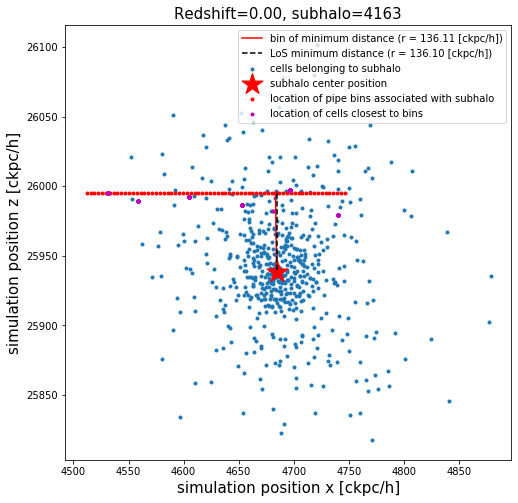

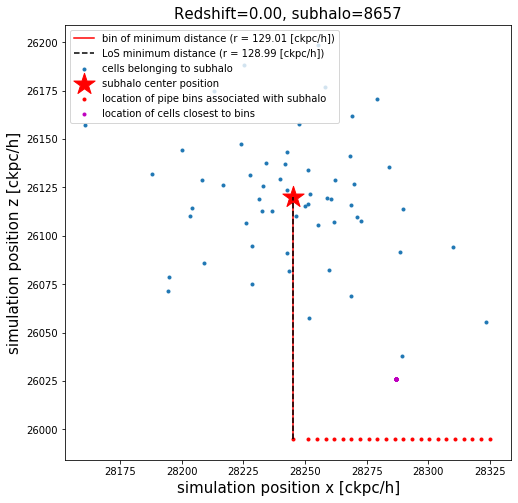

In [12]:
#adapted from https://www.tng-project.org/data/forum/topic/477/issue-with-getting-plots-for-particular-elliptical/


#plot all cells for a particular subhalo, 
#plus its central position
#plus the locations of the pipe bins which are associeated with it

#Warning: will not work if the subhalo ID is -1
print(np.all(np.unique(pipe_nearest_shIDs_p)))
if np.all(np.unique(pipe_nearest_shIDs_p)) == -1:
    print('Warning, only subhalo ID in pipe is -1. code will not work.')

else:
    subhalos_unique = np.unique(pipe_nearest_shIDs_p)
    subhalos_not_neg1 = np.where(subhalos_unique!=-1)
    subhalos_not_neg1 = subhalos_unique[subhalos_not_neg1]
    print('Subhalos which are not -1: {0}'.format(subhalos_not_neg1))

####################
#loop over subhalos#
####################

for subhalo_tochoose in subhalos_not_neg1: #for each subhalo which is not -1:
    
#subhalo_tochoose = np.random.choice(subhalos_not_neg1)

    print('Will plot subhalo {0}'.format(subhalo_tochoose))

    for (i,j) in zip([snap_number],[subhalo_tochoose]):
        print(i,j)

        #################################################
        #identify every bin associated with this subhalo#
        #################################################

        tochoose_bin_idxs = np.where(pipe_nearest_shIDs_p==j)

        ###################################
        #get the coordinates of these bins#
        ###################################

        #Note: decision should be made as to whether it is correct to choose the coordinate of the los bin, or
        #the coordinate of the closest cell (as that is where the electron density is)


        #tochoose_bin_coords = pipe_nearest_coords_p[tochoose_bin_idxs] #if using closest cell
        tochoose_bin_coords = pipe_bin_coords[tochoose_bin_idxs] #if using los bins

        print('Coordinates of bins belonging to this subhalo: {0}'.format(len(tochoose_bin_coords)))
        #print(tochoose_bin_coords)

        gas = il.snapshot.loadSubhalo(basePath, i, j, 'gas', fields=None)
        subhalo = il.groupcat.loadSingle(basePath, i, subhaloID=j)

        ##########################################################
        #identify the central position of the subhalo in question#
        ##########################################################

        centralpos = subhalo['SubhaloPos']
        print('Central position of subhalo: {0}'.format(centralpos))
        
        ################################################
        #extract other important data about the subhalo#
        ################################################
    
        print(subhalo.keys())

        ####################################################################################
        #calculate the distances between these bins and the central position of the subhalo#
        ####################################################################################

        dists = np.sqrt((tochoose_bin_coords[:,0]-centralpos[0])**2 + (tochoose_bin_coords[:,1]-centralpos[1])**2 + (tochoose_bin_coords[:,2]-centralpos[2])**2)
        minDist_idx = np.argmin(dists) #index of the bin with the minimum distance
        minDist = dists[minDist_idx] #actual minimum distance (rough impact factor without algebra)
        minDist_loc = tochoose_bin_coords[minDist_idx] #coordinates of bin of minimum distance
        print('Minimum distance (from a bin): {0}'.format(minDist))

        ####################################################################################
        #also calculate the true minimum distance between the LoS and the central position.#
        #This is where the LoS x coordinate is equal to that of the subhalo.               #
        #Note: y and z are always the same for a given LoS using zhang method.             #
        ####################################################################################

        true_min_coords = [tochoose_bin_coords[0,:]][0] #get placeholder coordinates for the point of minimum distance
        print('placeholder coordinates: {0}'.format(true_min_coords))
        print('closest x coordinate: {0}'.format(centralpos[0]))
        true_min_coords[0] = centralpos[0] #set central position equal to that of subhalo
        print('true min distance coordinate: {0}'.format(true_min_coords))
        true_minDist = np.sqrt(((true_min_coords[0]-centralpos[0])**2) + ((true_min_coords[1]-centralpos[1])**2) + ((true_min_coords[2]-centralpos[2])**2))
        print('Minimum distance (from LoS): {0}'.format(true_minDist))
        #plot

        if ('Coordinates' in gas.keys() ):
            #header = il.groupcat.loadHeader(basePath,i)

            gas_pos =(gas['Coordinates'])
            #sub_pos = subhalo['SubhaloPos']
            #print(sub_pos)

            #cells in the subhalo
            dx = gas_pos[:,0]# -  sub_pos[0]
            dy = gas_pos[:,1]# -  sub_pos[1]
            dz = gas_pos[:,2]# -  sub_pos[2]

            #central position of the subhalo
            cx = centralpos[0]
            cy = centralpos[1]
            cz = centralpos[2]

            #bins associated with subhalo
            bx = tochoose_bin_coords[:,0]
            by = tochoose_bin_coords[:,1]
            bz = tochoose_bin_coords[:,2]

            #true coordinates of the cells associated with those bins:
            tcx = pipe_nearest_coords_p[tochoose_bin_idxs][:,0]
            tcy = pipe_nearest_coords_p[tochoose_bin_idxs][:,1]
            tcz = pipe_nearest_coords_p[tochoose_bin_idxs][:,2]

            #minimum distance from a bin location
            mbx = minDist_loc[0]
            mby = minDist_loc[1]
            mbz = minDist_loc[2]

            #minimum distance from the LoS
            mlx = true_min_coords[0]
            mly = true_min_coords[1]
            mlz = true_min_coords[2]

            #print(bx,by,bz)

            fig = plt.figure(figsize=(8,8))
            ax = fig.add_subplot(111)
            ax.set_title("Redshift={0:.2f}, subhalo={1}".format(header['Redshift'],subhalo_tochoose),fontsize=15)
            ax.set_xlabel('simulation position x [ckpc/h]',fontsize=15)
            ax.set_ylabel('simulation position z [ckpc/h]',fontsize=15)

            ax.scatter(dx, dz, marker='.',label='cells belonging to subhalo')
            ax.scatter(cx,cz,color='r',marker='*',s=500,label='subhalo center position')
            ax.scatter(bx,bz,color='r',marker='.',label='location of pipe bins associated with subhalo')
            ax.scatter(tcx,tcz,color='m',marker='.',label='location of cells closest to bins')
            ax.plot([mbx,cx],[mbz,cz],color='r',label = 'bin of minimum distance (r = {0:.2f} [ckpc/h])'.format(minDist))
            ax.plot([mlx,cx],[mlz,cz],ls='--',color='k',label = 'LoS minimum distance (r = {0:.2f} [ckpc/h])'.format(true_minDist))
            plt.legend()
            plt.savefig('Impact_factor_test_{0}.png'.format(sim_to_use))



In [6]:
print('{0:02d}'.format(1))

01


In [7]:
testy = []
for i in testy:
    print(i)
